In [234]:
import numpy as np
import pandas as pd
import numpy.random as nprd
from tqdm import tqdm
from scipy.stats import gamma
import os
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

In [199]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [300]:
class Problem:
    def __init__(self, data: str, coefs: list[int], n_iter: int, seed: int = 123) -> None:
        nprd.seed(seed)
        self.y = pd.read_csv('acc_usines.txt', header=None)[0].to_numpy()
        self.T = len(self.y)
        self.n_iter = n_iter
        self.coefs = coefs
        self.a1 = coefs[0]
        self.a2 = coefs[1]
        self.d1 = coefs[2]
        self.d2 = coefs[3]
        self.init()
        sns.set_theme()
        sns.color_palette("pastel")
        plt.style.use('seaborn-v0_8-darkgrid')


    def init(self):
        self.ld = nprd.choice(np.arange(1, self.T))
        self.gamma = nprd.gamma(self.a1, self.a2)
        self.delta = nprd.gamma(self.d1, self.d2)
        self.lds = [self.ld]
        self.gammas = [self.gamma]
        self.deltas = [self.delta]

    def probs(self):
        probs = np.array([np.exp(-ld*(self.gamma - self.delta)) * self.gamma**(np.sum(self.y[:ld])) * self.delta**(np.sum(self.y[ld])) for ld in range(1, self.T)])
        probs /= np.sum(probs)
        return probs

    def flambda(self):
        self.ld = nprd.choice(a=np.arange(1, self.T), p=self.probs())

        # u = nprd.uniform()
        # if tmp / self.ld <= u:
        #     self.ld = tmp

        self.lds.append(self.ld)

    def fgamma(self):
        a = self.a1 + np.sum(self.y[:self.ld])
        b = self.a2 + self.ld
        self.gamma = nprd.gamma(a, 1/b)
        self.gammas.append(self.gamma)

    def fdelta(self):
        a = self.d1 + np.sum(self.y[self.ld:])
        b = self.d2 + (self.T - self.ld)
        self.delta = nprd.gamma(a, 1/b)
        self.deltas.append(self.delta)

    def simulate(self):
        for i in tqdm(range(self.n_iter)):
            self.fgamma()
            self.fdelta()
            self.flambda()

        self.lds = np.array(self.lds)
        self.gammas = np.array(self.gammas)
        self.deltas = np.array(self.deltas)
        self.ld_mean = int(np.round(np.mean(self.lds)))
        self.ld_std = np.std(self.lds)

    def __call__(self):
        self.simulate()

    def ld_hist(self, save=None):
        fig, ax = plt.subplots()
        sns.histplot(self.lds, ax=ax, bins=150)
        ax.set(xlabel=r"$\lambda$", title=rf"Count of $\lambda$ over {self.n_iter} iterations")

        if save is not None:
            fig.savefig(save)

    def ld_line(self, save=None):
        fig, ax = plt.subplots()
        sns.lineplot(self.lds, ax=ax)
        ax.set(xlabel="Iteration", ylabel=r"$\lambda$", title=rf"Evolution of $\lambda$ over {self.n_iter} iterations")

        if save is not None:
            fig.savefig(save)

    def gamma_delta_lines(self, save=None):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        sns.lineplot(self.gammas, ax=ax1)
        sns.lineplot(self.deltas, ax=ax2)
        ax1.set(xlabel="Iteration", ylabel=r"$\gamma$", title=rf"Evolution of $\gamma$ over {self.n_iter} iterations")
        ax2.set(xlabel="Iteration", ylabel=r"$\delta$", title=rf"Evolution of $\delta$ over {self.n_iter} iterations")

        if save is not None:
            fig.savefig(save)

    def gamma_delta_hists(self, save=None):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        sns.histplot(self.gammas, ax=ax1, bins=150)
        sns.histplot(self.deltas, ax=ax2, bins=150)
        ax1.set(xlabel=r"$\gamma$", title=rf"Count of $\gamma$ over {self.n_iter} iterations")
        ax2.set(xlabel=r"$\delta$", title=rf"Count of $\delta$ over {self.n_iter} iterations")

        if save is not None:
            fig.savefig(save)

    def data_line(self, save=None):
        fig, ax = plt.subplots()
        x = np.arange(self.T)
        ax.plot(x[:self.ld_mean + 1], self.y[:self.ld_mean + 1], label="Avant le changement")
        ax.plot(x[self.ld_mean:], self.y[self.ld_mean:], label="Après le changement")
        ax.axvline(x=self.ld_mean, linestyle ='--', color='r', label=rf"Moyenne des $\lambda={self.ld_mean}$ avec une variance de ${self.ld_std:.2f}$")
        ax.set(xlabel=r"$t$", ylabel=rf"Valeur de $y_t$", title=rf"Évolution de $y_t$ au cours du temps")
        plt.legend()

        if save is not None:
            fig.savefig(save)

    def generate_plots(self):
        mydir = os.path.join('./images', '_'.join([str(_) for _ in self.coefs]), datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
        os.makedirs(mydir)
        self.ld_hist(f'{mydir}/ld_hist.png')
        self.ld_line(f'{mydir}/ld_line.png')
        self.gamma_delta_lines(f'{mydir}/gamma_delta_lines.png')
        self.gamma_delta_hists(f'{mydir}/gamma_delta_hists.png')
        self.data_line(f'{mydir}/data_line.png');

In [301]:
test = Problem('acc_usines.txt', [1, 0.5, 0.5, 0.5], 5000, 214)

In [302]:
test()

100%|██████████| 5000/5000 [00:05<00:00, 921.07it/s]


In [326]:
tmp = test.y[test.ld_mean:]
tmp.mean(), tmp.std(), np.median(tmp)

(0.9315068493150684, 1.024745436124112, 1.0)

In [327]:
tmp = test.y[:test.ld_mean]
tmp.mean(), tmp.std(), np.median(tmp)

(3.1538461538461537, 1.5938738736328262, 3.0)

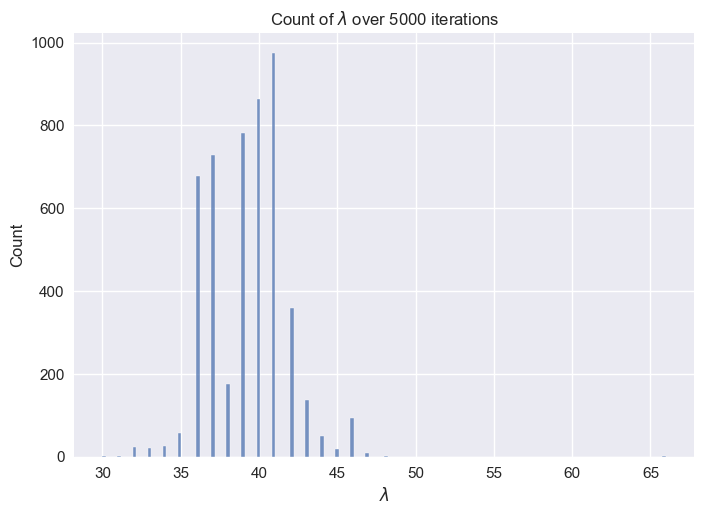

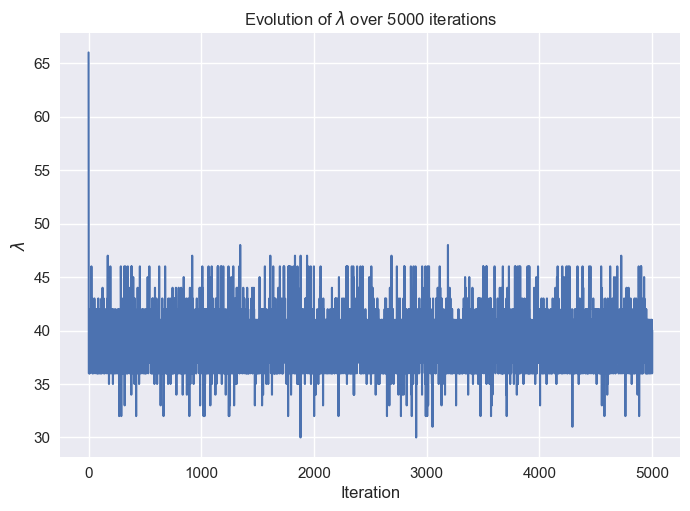

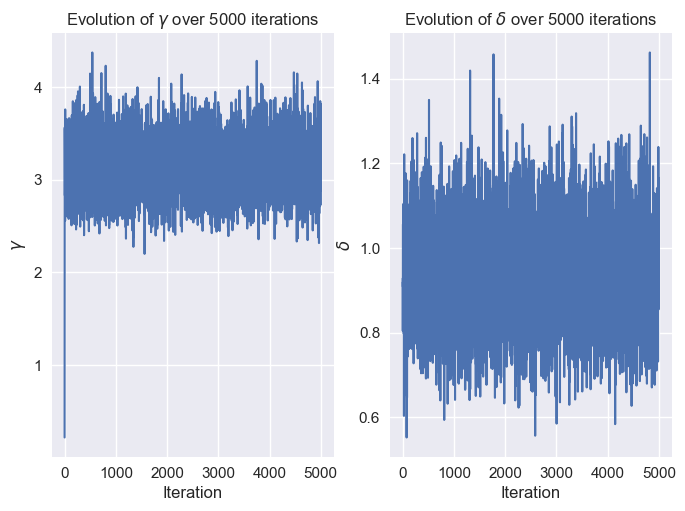

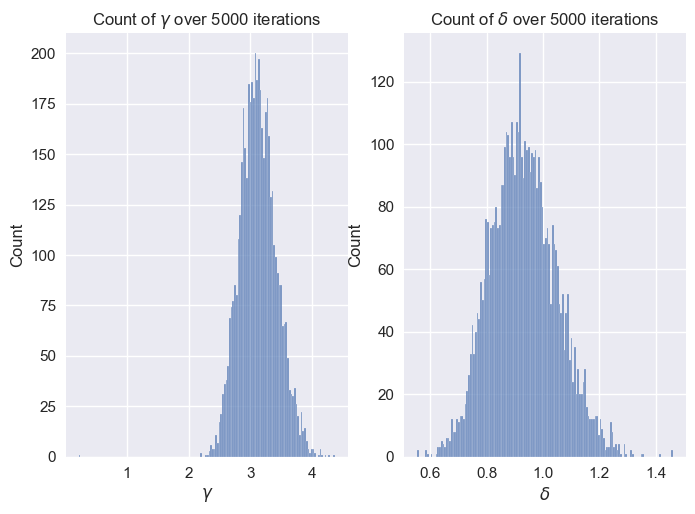

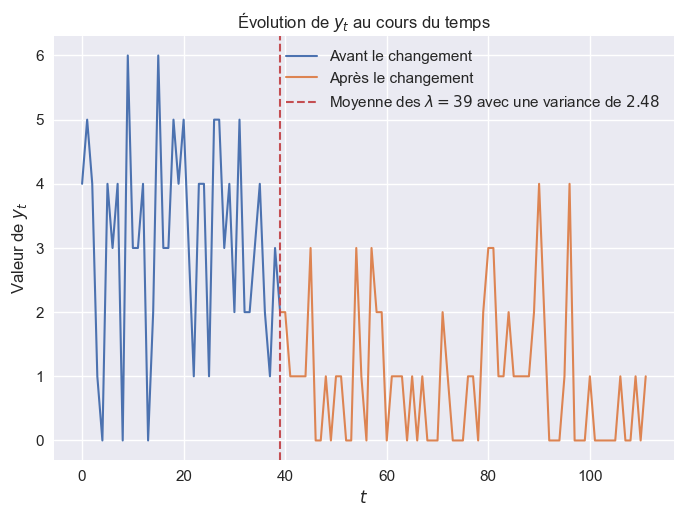

In [303]:
test.generate_plots()

In [320]:
test2 = Problem('acc_usines.txt', [1, 1, 1, 1], 5000, 214)

In [321]:
test2()

100%|██████████| 5000/5000 [00:05<00:00, 920.29it/s]


In [322]:
test2.lds.mean(), test2.lds.std(), np.median(test2.lds)

(39.33133373325335, 2.4951053866764257, 40.0)

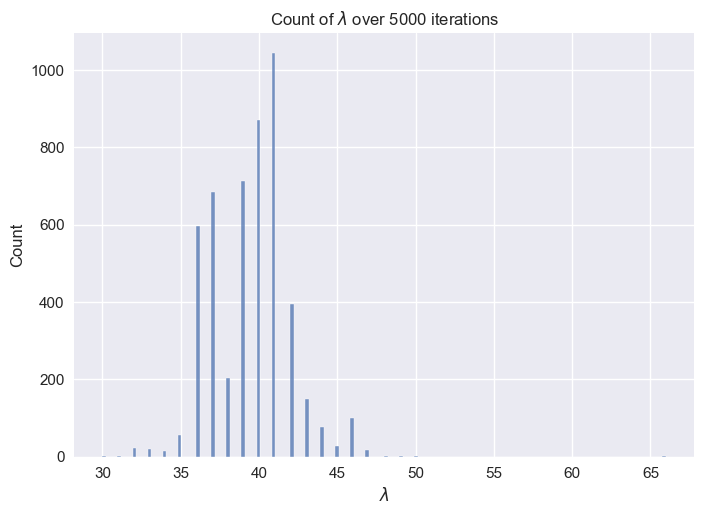

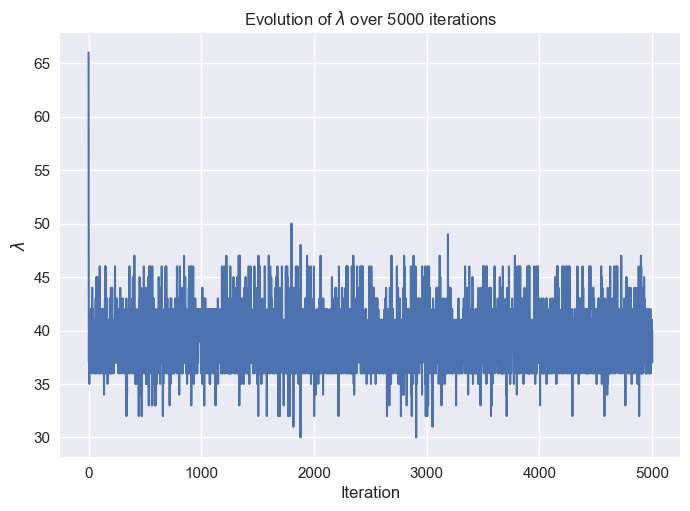

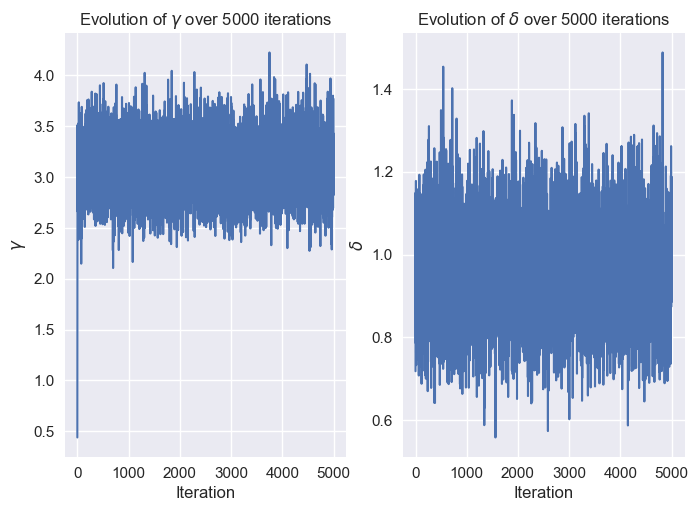

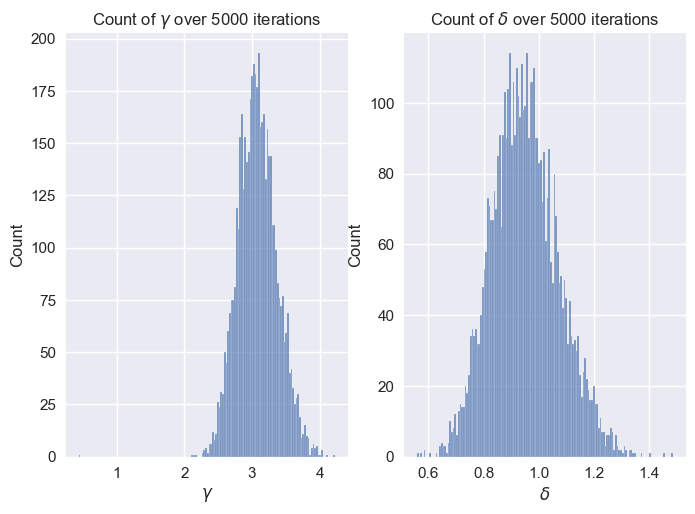

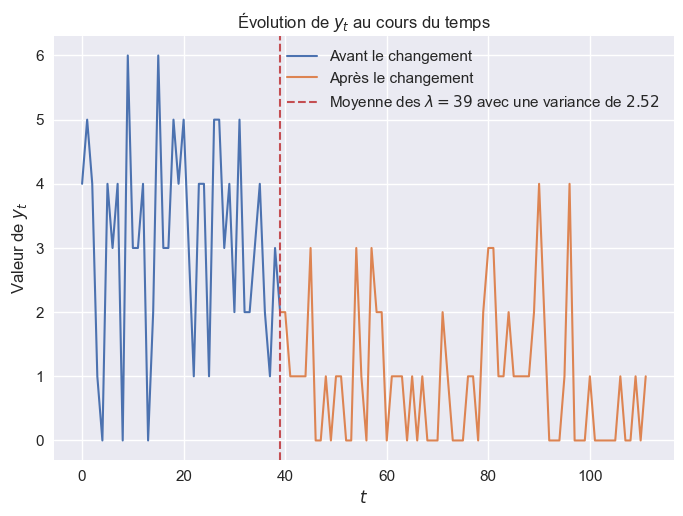

In [315]:
test2.generate_plots()